In [42]:
# Import statements

import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, count, when, year, month, explode, array_contains, lower, array_join, to_date, concat_ws, expr, coalesce, lit
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import numpy as np

In [43]:
# Create or get the spark session

spark_session = SparkSession \
    .builder \
    .appName("s4768708_project") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

spark_session

24/05/16 10:10:06 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
24/05/16 10:11:11 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


In [3]:
# Load the dataset - All files

df_load = spark_session.read.json("/data/ProjectDatasetFacebookAU/*")

In [4]:
# Check the schema and number of rows in the dataset

print("DATASET SCHEMA")
df_load.printSchema()
print("\nTotal Count:")
print(df_load.count())

DATASET SCHEMA
root
 |-- ad_creation_time: string (nullable = true)
 |-- ad_creative_bodies: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_body: string (nullable = true)
 |-- ad_creative_link_caption: string (nullable = true)
 |-- ad_creative_link_captions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_link_description: string (nullable = true)
 |-- ad_creative_link_descriptions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_link_title: string (nullable = true)
 |-- ad_creative_link_titles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_delivery_start_time: string (nullable = true)
 |-- ad_delivery_stop_time: string (nullable = true)
 |-- ad_snapshot_url: string (nullable = true)
 |-- bylines: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- delivery_by_region: array (nullable = true)
 |    |-- element: st

39584139


In [5]:
df_load.head(1)

24/05/12 10:22:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(ad_creation_time='2021-11-21', ad_creative_bodies=None, ad_creative_body="I'm ready to fight Scott Morrison's Cashless Pension Card being rolled out in Lilley.", ad_creative_link_caption=None, ad_creative_link_captions=None, ad_creative_link_description=None, ad_creative_link_descriptions=None, ad_creative_link_title='Cashless Pension Card', ad_creative_link_titles=None, ad_delivery_start_time='2021-11-21', ad_delivery_stop_time=None, ad_snapshot_url='https://www.facebook.com/ads/archive/render_ad/?id=966461410889234&access_token=EAAG7mM7GdIsBADfD3puwsjZBZCoYLv4bKLXwzw6Fdne1DYSDXo0je6isRr8yEgaZAxFncyzRs1RPJxebw77MaXZBI12hOs9cjPVAN11L4vrY6ddT1dEZCoEOFje4uBkA1Nn6kY3FkgO7zZBNpxUpkq2ijrzRaa2Mm1EyZCGdz3KcS6KDaHduw6NfcorBcQwKq0ZD', bylines=None, currency='AUD', delivery_by_region=None, demographic_distribution=[Row(age='55-64', gender='unknown', percentage='0.001232'), Row(age='65+', gender='unknown', percentage='0.017252'), Row(age='55-64', gender='female', percentage='0.057917'), Row(

In [6]:
# Drop the duplicate records with respect to 'id' column

df_id_unique = df_load.dropDuplicates(subset=['id'])
print("\nTotal Count:")
print(df_id_unique.count())


Total Count:


11852904


In [7]:
# Check the null values in each column

missing_counts = df_id_unique.select([count(when(col(c).isNull(), c)).alias(c) for c in df_id_unique.columns]).toPandas().T
print(missing_counts)

                                      0
ad_creation_time                      0
ad_creative_bodies              1040180
ad_creative_body               11626150
ad_creative_link_caption       11695969
ad_creative_link_captions        742448
ad_creative_link_description   11725413
ad_creative_link_descriptions   6698914
ad_creative_link_title         11691941
ad_creative_link_titles         2622006
ad_delivery_start_time                0
ad_delivery_stop_time          11841292
ad_snapshot_url                       0
bylines                        11651858
currency                       11420317
delivery_by_region             11695747
demographic_distribution       11486015
estimated_audience_size        11651460
funding_entity                 11429688
id                                    0
impressions                    11420317
languages                       3867935
page_id                               0
page_name                            41
publisher_platforms              229683


In [8]:
# Calculate the publisher platforms for the ads

exploded_unique_df = df_id_unique.select(explode('publisher_platforms').alias('platform'))
platform_counts = exploded_unique_df.groupBy('platform').count()
platform_counts.show()

+----------------+--------+
|        platform|   count|
+----------------+--------+
|       instagram|10393233|
|       messenger| 8581755|
|audience_network| 8659028|
|        facebook|10734659|
+----------------+--------+



In [9]:
# Search the specific columns for the election words and filter the dataset

columns_to_search = [
    'ad_creative_body',
    'ad_creative_bodies',
    'ad_creative_link_caption',
    'ad_creative_link_captions',
    'ad_creative_link_description',
    'ad_creative_link_descriptions',
    'ad_creative_link_title',
    'ad_creative_link_titles'
]

words_to_search = ['vote', 'voting', 'federal', 'election', 'elections', 'Australian Federal election', 'Anthony', 'Albanese',
                  'Scott', 'Morrison', 'Adam', 'Bandt', 'Liberal', 'Labor', 'Greens', 'party']

# Create an empty DataFrame to collect the filtered results
filtered_df = spark_session.createDataFrame([], df_id_unique.schema)

# Loop through each word to search for
for word in words_to_search:
    # Initialize the filter condition
    word_filter = None
    # Loop through each column to search in
    for column in columns_to_search:
        # Apply lowercase transformation and concatenate array elements into a single string
        if '_bodies' in column or '_captions' in column or '_descriptions' in column or '_titles' in column:
            concatenated_string = lower(array_join(col(column), " "))
        else:
            concatenated_string = lower(col(column))
        # Check if the concatenated string contains the search word
        condition = concatenated_string.contains(word.lower())
        # Union the filtered results with the existing DataFrame
        if word_filter is None:
            word_filter = condition
        else:
            word_filter = word_filter | condition
    # Filter the DataFrame based on the current word and union the results
    filtered_df = filtered_df.union(df_id_unique.filter(word_filter))

print("\nTotal Count:")
print(filtered_df.count())


Total Count:


696981


In [10]:
# Drop the duplicate records with respect to 'id' column on the filtered_df

filtered_df_id_unique = filtered_df.dropDuplicates(subset=['id'])
print("\nTotal Count:")
print(filtered_df_id_unique.count())


Total Count:


532931


In [11]:
# Filter the DataFrame based on the ad_creation_time column

election_df = filtered_df_id_unique.filter(to_date(col("ad_creation_time"), "yyyy-MM-dd") < "2022-07-01")
election_df = election_df.dropDuplicates(subset=['id'])
print("\nTotal Count:")
print(election_df.count())


Total Count:


95299


In [12]:
# Check the null values in each column

missing_counts_election = election_df.select([count(when(col(c).isNull(), c)).alias(c) for c in election_df.columns]).toPandas().T
print(missing_counts_election)

24/05/12 10:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1148.7 KiB


                                   0
ad_creation_time                   0
ad_creative_bodies             94050
ad_creative_body                1764
ad_creative_link_caption       37129
ad_creative_link_captions      94491
ad_creative_link_description   51303
ad_creative_link_descriptions  94801
ad_creative_link_title         36001
ad_creative_link_titles        94526
ad_delivery_start_time             0
ad_delivery_stop_time          92359
ad_snapshot_url                    0
bylines                        94038
currency                           0
delivery_by_region             94191
demographic_distribution        6604
estimated_audience_size        94039
funding_entity                    81
id                                 0
impressions                        0
languages                      94039
page_id                            0
page_name                          0
publisher_platforms            94032
region_distribution             6604
spend                              0


In [13]:
# Get the most used words in the text columns

#def preprocess_text(text):
#    # Convert to lowercase
#    text = text.lower()
    
#    # Remove punctuations
#    text = re.sub(r'[{}]'.format(string.punctuation), '', text)
    
#    # Remove prepositions and common words
#    common_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "you're", "you've", "you'll", "you'd", "your",
#                    "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "she's", "her", "hers", "herself", "it",
#                    "it's", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this",
#                    "that", "that'll", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had",
#                    "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
#                    "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above",
#                    "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
#                    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no",
#                    "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "don't", "should",
#                    "should've", "now", "d", "ll", "m", "o", "re", "ve", "y", "ain", "aren", "aren't", "couldn", "couldn't", "didn", "didn't",
#                    "doesn", "doesn't", "hadn", "hadn't", "hasn", "hasn't", "haven", "haven't", "isn", "isn't", "ma", "mightn", "mightn't",
#                    "mustn", "mustn't", "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't", "wasn", "wasn't", "weren", "weren't",
#                    "won", "won't", "wouldn", "wouldn't", "plan", "make", "need", "new", "future", "1", "get", "better", "help", "us",
#                    "climate", "time", "like", "care", "one", "–", "que", "want", "back", "work", "today", "find", "year", "years", "animal",
#                    "see", "action", "mp", "de", "sign", "keep", "know", "take", "would", "early", "ward", "strong", "first", "city",
#                    "also", "every", "many", "join", "✅", "day", "animals", "last", "could", "wa"]
#    
#    text = ' '.join(word for word in text.split() if word not in common_words)
    
#    return text

#def get_combined_text(row):
#    text = ""
#    for column in ['ad_creative_body', 'ad_creative_link_caption', 'ad_creative_link_description', 'ad_creative_link_title']:
#        if row[column]:
#            text += preprocess_text(row[column]) + " "
    
#    for column in ['ad_creative_bodies', 'ad_creative_link_captions', 'ad_creative_link_descriptions', 'ad_creative_link_titles']:
#        if row[column]:
#            text += " ".join(preprocess_text(item) for item in row[column]) + " "
    
#    return text.strip()

## Combine text from all relevant columns
#temp_df = election_df
#combined_text = temp_df.rdd.map(get_combined_text).filter(lambda x: x)

## Count word frequencies
#word_counts = combined_text.flatMap(lambda text: text.split()).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)

## Get the top 50 words
#top_words = word_counts.takeOrdered(50, key=lambda x: (-x[1], x[0]))

## Print the top 50 words
#for word, count in top_words:
#    print(f"{word}: {count}")

In [14]:
# Check the top 50 pages with count

page_counts = election_df.groupBy("page_id", "page_name").agg(count("*").alias("count"))
page_counts = page_counts.orderBy("count", ascending=False)
page_counts.select("page_id", "page_name", "count").show(50,truncate=False)

+----------------+-------------------------------------------------+-----+
|page_id         |page_name                                        |count|
+----------------+-------------------------------------------------+-----+
|307341981788    |Australian Labor Party                           |4851 |
|13561467463     |Liberal Party of Australia                       |3208 |
|397230473694314 |Queensland Labor                                 |1300 |
|104389532222332 |Solutions                                        |1196 |
|165242077409311 |Australian Automobile Association                |1133 |
|537762462924537 |Anthony Albanese                                 |992  |
|121201504755819 |Animal Justice Party AJP Victoria                |878  |
|9480502970      |Greenpeace Australia Pacific                     |873  |
|13527056454     |GetUp!                                           |815  |
|464998863536680 |Bill Shorten                                     |795  |
|879712192044319 |Animal 

In [15]:
# Filter the ads for Labor, Liberal, and Greens parties from the top 50 pages

labor_page_ids = ['307341981788', '397230473694314', '537762462924537', '464998863536680', '113830088678537', '132800873768451',
                  '427125817373739', '174666115898903', '136238709722696', '1501550403427903', '146809615402166', '186985648081724',
                  '581391495214301', '324660077589275', '101445619187940']
liberal_page_ids = ['13561467463', '44701328033', '100797488277640', '352953834815624', '137619162220', '214559598616472', '185917314792939',
                    '275866669090583', '162107547181406', '292602604891']
greens_page_ids = ['108695110952294', '119931654696956', '21551986502']

# Filter the DataFrame based on the page IDs for each party
labor_df = election_df.filter(col("page_id").isin(labor_page_ids))
liberal_df = election_df.filter(col("page_id").isin(liberal_page_ids))
greens_df = election_df.filter(col("page_id").isin(greens_page_ids))

print("\nCounts for labor party:")
print(labor_df.count())
print("\nCounts for liberal party:")
print(liberal_df.count())
print("\nCounts for greens party:")
print(greens_df.count())


Counts for labor party:


12241

Counts for liberal party:


6253

Counts for greens party:


1409


In [16]:
# Check the null values against each column for each part dataframe:

missing_counts_labor = labor_df.select([count(when(col(c).isNull(), c)).alias(c) for c in labor_df.columns]).toPandas().T
print("Missing counts for Labor Party:")
print(missing_counts_labor)

missing_counts_liberal = liberal_df.select([count(when(col(c).isNull(), c)).alias(c) for c in liberal_df.columns]).toPandas().T
print("Missing counts for Liberal Party:")
print(missing_counts_liberal)

missing_counts_greens = greens_df.select([count(when(col(c).isNull(), c)).alias(c) for c in greens_df.columns]).toPandas().T
print("Missing counts for Greens Party:")
print(missing_counts_greens)

24/05/12 10:34:23 WARN DAGScheduler: Broadcasting large task binary with size 1148.7 KiB


Missing counts for Labor Party:
                                   0
ad_creation_time                   0
ad_creative_bodies             12183
ad_creative_body                  72
ad_creative_link_caption        3283
ad_creative_link_captions      12185
ad_creative_link_description    5518
ad_creative_link_descriptions  12227
ad_creative_link_title          4092
ad_creative_link_titles        12185
ad_delivery_start_time             0
ad_delivery_stop_time          12003
ad_snapshot_url                    0
bylines                        12183
currency                           0
delivery_by_region             12214
demographic_distribution        1417
estimated_audience_size        12183
funding_entity                     0
id                                 0
impressions                        0
languages                      12186
page_id                            0
page_name                          0
publisher_platforms            12183
region_distribution             1417
spend 

24/05/12 10:36:03 WARN DAGScheduler: Broadcasting large task binary with size 1148.7 KiB


Missing counts for Liberal Party:
                                  0
ad_creation_time                  0
ad_creative_bodies             6246
ad_creative_body                 22
ad_creative_link_caption       1615
ad_creative_link_captions      6253
ad_creative_link_description   2212
ad_creative_link_descriptions  6253
ad_creative_link_title         1399
ad_creative_link_titles        6253
ad_delivery_start_time            0
ad_delivery_stop_time          6035
ad_snapshot_url                   0
bylines                        6246
currency                          0
delivery_by_region             6246
demographic_distribution        831
estimated_audience_size        6246
funding_entity                    0
id                                0
impressions                       0
languages                      6246
page_id                           0
page_name                         0
publisher_platforms            6246
region_distribution             831
spend                         

24/05/12 10:37:29 WARN DAGScheduler: Broadcasting large task binary with size 1148.7 KiB


Missing counts for Greens Party:
                                  0
ad_creation_time                  0
ad_creative_bodies             1389
ad_creative_body                 25
ad_creative_link_caption         87
ad_creative_link_captions      1389
ad_creative_link_description    694
ad_creative_link_descriptions  1399
ad_creative_link_title           94
ad_creative_link_titles        1389
ad_delivery_start_time            0
ad_delivery_stop_time          1371
ad_snapshot_url                   0
bylines                        1389
currency                          0
delivery_by_region             1389
demographic_distribution         26
estimated_audience_size        1389
funding_entity                    0
id                                0
impressions                       0
languages                      1390
page_id                           0
page_name                         0
publisher_platforms            1389
region_distribution              26
spend                          

In [17]:
# Check the currencies used by each party

distinct_currencies_labor = labor_df.select("currency").distinct()
print("\nCurrencies for Labor Party:")
distinct_currencies_labor.show()

distinct_currencies_liberal = liberal_df.select("currency").distinct()
print("\nCurrencies for Liberal Party:")
distinct_currencies_liberal.show()

distinct_currencies_greens = greens_df.select("currency").distinct()
print("\nCurrencies for Greens Party:")
distinct_currencies_greens.show()


Currencies for Labor Party:


+--------+
|currency|
+--------+
|     AUD|
+--------+


Currencies for Liberal Party:


+--------+
|currency|
+--------+
|     AUD|
+--------+


Currencies for Greens Party:


+--------+
|currency|
+--------+
|     AUD|
+--------+



In [18]:
#Calculate the spend for each party with lower_bound and upper_bound

# Replace None values with 0 before summing
labor_df = labor_df.withColumn("spend_lower_bound", when(col("spend.lower_bound").isNull(), 0).otherwise(col("spend.lower_bound")))
labor_df = labor_df.withColumn("spend_upper_bound", when(col("spend.upper_bound").isNull(), 0).otherwise(col("spend.upper_bound")))
liberal_df = liberal_df.withColumn("spend_lower_bound", when(col("spend.lower_bound").isNull(), 0).otherwise(col("spend.lower_bound")))
liberal_df = liberal_df.withColumn("spend_upper_bound", when(col("spend.upper_bound").isNull(), 0).otherwise(col("spend.upper_bound")))
greens_df = greens_df.withColumn("spend_lower_bound", when(col("spend.lower_bound").isNull(), 0).otherwise(col("spend.lower_bound")))
greens_df = greens_df.withColumn("spend_upper_bound", when(col("spend.upper_bound").isNull(), 0).otherwise(col("spend.upper_bound")))

# Calculate the sum of lower_bound and upper_bound values
labor_spend_lower = labor_df.selectExpr("sum(CAST(spend_lower_bound AS FLOAT)) AS spend_lower_bound").collect()[0]["spend_lower_bound"]
labor_spend_upper = labor_df.selectExpr("sum(CAST(spend_upper_bound AS FLOAT)) AS spend_upper_bound").collect()[0]["spend_upper_bound"]
liberal_spend_lower = liberal_df.selectExpr("sum(CAST(spend_lower_bound AS FLOAT)) AS spend_lower_bound").collect()[0]["spend_lower_bound"]
liberal_spend_upper = liberal_df.selectExpr("sum(CAST(spend_upper_bound AS FLOAT)) AS spend_upper_bound").collect()[0]["spend_upper_bound"]
greens_spend_lower = greens_df.selectExpr("sum(CAST(spend_lower_bound AS FLOAT)) AS spend_lower_bound").collect()[0]["spend_lower_bound"]
greens_spend_upper = greens_df.selectExpr("sum(CAST(spend_upper_bound AS FLOAT)) AS spend_upper_bound").collect()[0]["spend_upper_bound"]

print("Overall Spend Labor:")
print(f"Spend Lower Bound: {labor_spend_lower}")
print(f"Spend Upper Bound: {labor_spend_upper}")
print("\nOverall Spend Liberal:")
print(f"Spend Lower Bound: {liberal_spend_lower}")
print(f"Spend Upper Bound: {liberal_spend_upper}")
print("\nOverall Spend Greens:")
print(f"Spend Lower Bound: {greens_spend_lower}")
print(f"Spend Upper Bound: {greens_spend_upper}")

Overall Spend Labor:
Spend Lower Bound: 1655700.0
Spend Upper Bound: 3050157.0

Overall Spend Liberal:
Spend Lower Bound: 822000.0
Spend Upper Bound: 1582247.0

Overall Spend Greens:
Spend Lower Bound: 129100.0
Spend Upper Bound: 273191.0


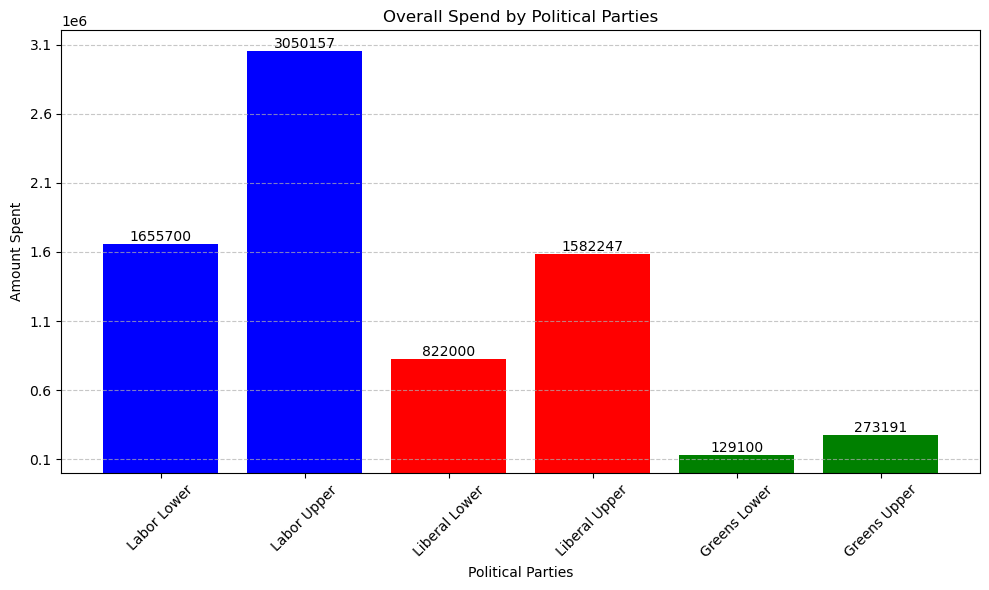

In [19]:
# Plot the spend plot for each party

# X-axis labels
labels = ['Labor Lower', 'Labor Upper', 'Liberal Lower', 'Liberal Upper', 'Greens Lower', 'Greens Upper']

# Spend values
spend_values = [labor_spend_lower, labor_spend_upper, liberal_spend_lower, liberal_spend_upper, greens_spend_lower, greens_spend_upper]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, spend_values, color=['blue', 'blue', 'red', 'red', 'green', 'green'])

# Adjust y-axis
plt.yticks(np.arange(100000, max(spend_values) + 500000, 500000))

# Adding labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%.0f' % height, ha='center', va='bottom')

plt.xlabel('Political Parties')
plt.ylabel('Amount Spent')
plt.title('Overall Spend by Political Parties')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
#Calculate the impressions for each party with lower_bound and upper_bound

# Replace None values with 0 before summing
labor_df = labor_df.withColumn("impressions_lower_bound", when(col("impressions.lower_bound").isNull(), 0).otherwise(col("impressions.lower_bound")))
labor_df = labor_df.withColumn("impressions_upper_bound", when(col("impressions.upper_bound").isNull(), 0).otherwise(col("impressions.upper_bound")))
liberal_df = liberal_df.withColumn("impressions_lower_bound", when(col("impressions.lower_bound").isNull(), 0).otherwise(col("impressions.lower_bound")))
liberal_df = liberal_df.withColumn("impressions_upper_bound", when(col("impressions.upper_bound").isNull(), 0).otherwise(col("impressions.upper_bound")))
greens_df = greens_df.withColumn("impressions_lower_bound", when(col("impressions.lower_bound").isNull(), 0).otherwise(col("impressions.lower_bound")))
greens_df = greens_df.withColumn("impressions_upper_bound", when(col("impressions.upper_bound").isNull(), 0).otherwise(col("impressions.upper_bound")))

# Calculate the sum of lower_bound and upper_bound values
labor_impressions_lower = labor_df.selectExpr("sum(CAST(impressions_lower_bound AS FLOAT)) AS impressions_lower_bound").collect()[0]["impressions_lower_bound"]
labor_impressions_upper = labor_df.selectExpr("sum(CAST(impressions_upper_bound AS FLOAT)) AS impressions_upper_bound").collect()[0]["impressions_upper_bound"]
liberal_impressions_lower = liberal_df.selectExpr("sum(CAST(impressions_lower_bound AS FLOAT)) AS impressions_lower_bound").collect()[0]["impressions_lower_bound"]
liberal_impressions_upper = liberal_df.selectExpr("sum(CAST(impressions_upper_bound AS FLOAT)) AS impressions_upper_bound").collect()[0]["impressions_upper_bound"]
greens_impressions_lower = greens_df.selectExpr("sum(CAST(impressions_lower_bound AS FLOAT)) AS impressions_lower_bound").collect()[0]["impressions_lower_bound"]
greens_impressions_upper = greens_df.selectExpr("sum(CAST(impressions_upper_bound AS FLOAT)) AS impressions_upper_bound").collect()[0]["impressions_upper_bound"]

print("Overall impressions Labor:")
print(f"impressions Lower Bound: {labor_impressions_lower}")
print(f"impressions Upper Bound: {labor_impressions_upper}")
print("\nOverall impressions Liberal:")
print(f"impressions Lower Bound: {liberal_impressions_lower}")
print(f"impressions Upper Bound: {liberal_impressions_upper}")
print("\nOverall impressions Greens:")
print(f"impressions Lower Bound: {greens_impressions_lower}")
print(f"impressions Upper Bound: {greens_impressions_upper}")

Overall impressions Labor:
impressions Lower Bound: 111605000.0
impressions Upper Bound: 144866756.0

Overall impressions Liberal:
impressions Lower Bound: 74203000.0
impressions Upper Bound: 86437748.0

Overall impressions Greens:
impressions Lower Bound: 9007000.0
impressions Upper Bound: 11754591.0


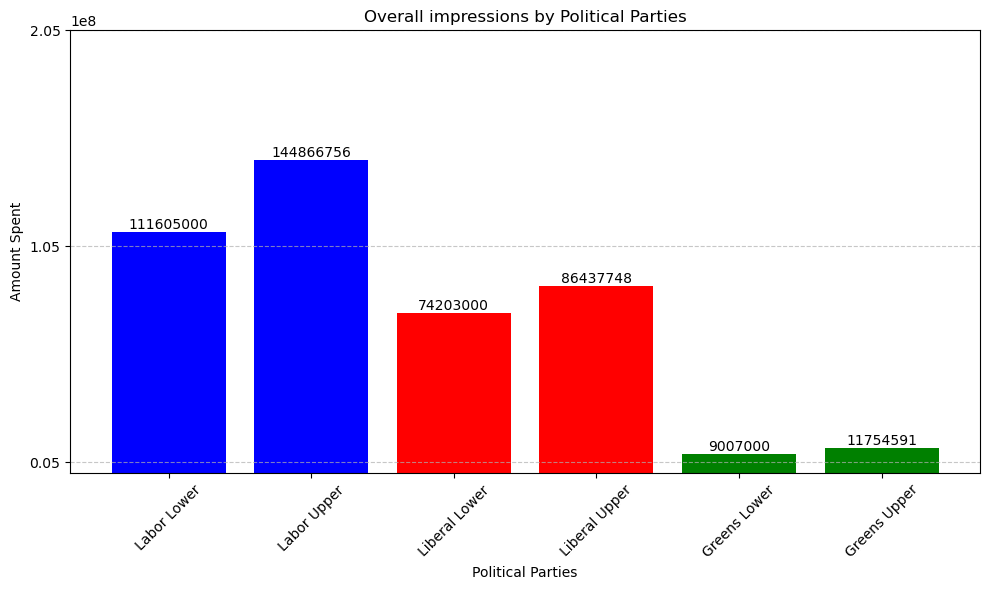

In [21]:
# Plot the impressions plot for each party

# X-axis labels
labels = ['Labor Lower', 'Labor Upper', 'Liberal Lower', 'Liberal Upper', 'Greens Lower', 'Greens Upper']

# impressions values
impressions_values = [labor_impressions_lower, labor_impressions_upper, liberal_impressions_lower, liberal_impressions_upper, greens_impressions_lower, greens_impressions_upper]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, impressions_values, color=['blue', 'blue', 'red', 'red', 'green', 'green'])

# Adjust y-axis
plt.yticks(np.arange(5000000, max(impressions_values) + 100000000, 100000000))

# Adding labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%.0f' % height, ha='center', va='bottom')

plt.xlabel('Political Parties')
plt.ylabel('Amount Spent')
plt.title('Overall impressions by Political Parties')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
# Calculate the region distribution in Australia for each party

# List of desired regions
desired_regions = ['Northern Territory', 'South Australia', 'Victoria', 'Western Australia', 'New South Wales', 'Tasmania', 'Queensland',
                   'Australian Capital Territory']

# Explode the array column 'region_distribution' and select the 'percentage' and 'region'
labor_exploded_df = labor_df.select(explode('region_distribution').alias('region_info')).select(col('region_info.percentage').cast('float').alias('percentage'), col('region_info.region'))
liberal_exploded_df = liberal_df.select(explode('region_distribution').alias('region_info')).select(col('region_info.percentage').cast('float').alias('percentage'), col('region_info.region'))
greens_exploded_df = greens_df.select(explode('region_distribution').alias('region_info')).select(col('region_info.percentage').cast('float').alias('percentage'), col('region_info.region'))

# Group by 'region' and calculate the sum of 'percentage' for each region
labor_region_sum_df = labor_exploded_df.groupBy('region').sum('percentage').withColumnRenamed('sum(percentage)', 'total_percentage')
labor_region_sum_df = labor_region_sum_df.filter(col('region').isin(desired_regions))
liberal_region_sum_df = liberal_exploded_df.groupBy('region').sum('percentage').withColumnRenamed('sum(percentage)', 'total_percentage')
liberal_region_sum_df = liberal_region_sum_df.filter(col('region').isin(desired_regions))
greens_region_sum_df = greens_exploded_df.groupBy('region').sum('percentage').withColumnRenamed('sum(percentage)', 'total_percentage')
greens_region_sum_df = greens_region_sum_df.filter(col('region').isin(desired_regions))

# Calculate proportions
labor_total_records = labor_df.count()
labor_region_sum_df = labor_region_sum_df.withColumn('proportion', (col('total_percentage') / labor_total_records) * 100)
liberal_total_records = liberal_df.count()
liberal_region_sum_df = liberal_region_sum_df.withColumn('proportion', (col('total_percentage') / liberal_total_records) * 100)
greens_total_records = greens_df.count()
greens_region_sum_df = greens_region_sum_df.withColumn('proportion', (col('total_percentage') / greens_total_records) * 100)

# Show the result
print("Labor Party")
labor_region_sum_df.show()
print("\nLiberal Party")
liberal_region_sum_df.show()
print("\nGreens Party")
greens_region_sum_df.show()

Labor Party


+--------------------+------------------+------------------+
|              region|  total_percentage|        proportion|
+--------------------+------------------+------------------+
|  Northern Territory|131.93312670269734|1.0773569059504928|
|     South Australia| 999.8021838952391| 8.164316380003585|
|            Victoria|2277.9406083552185|18.601507499226024|
|   Western Australia|  818.868728921696| 6.686826138508051|
|     New South Wales| 2568.696784590124| 20.97580258525334|
|Australian Capita...| 337.2697027728709| 2.754121368388624|
|            Tasmania| 432.1577129982834|3.5289703821515874|
|          Queensland|  3279.47692033567|  26.7799846507894|
+--------------------+------------------+------------------+


Liberal Party


+--------------------+------------------+------------------+
|              region|  total_percentage|        proportion|
+--------------------+------------------+------------------+
|  Northern Territory|  46.3869030056012|0.7418343675931744|
|     South Australia| 431.6129249289461| 6.902493601934209|
|            Victoria|1421.5782359584487| 22.73433929247479|
|   Western Australia| 658.7900710553458|10.535584056538395|
|     New South Wales|1114.9896256897205| 17.83127499903599|
|Australian Capita...| 329.7279631178135|  5.27311631405427|
|            Tasmania|198.18052592201275| 3.169367118535307|
|          Queensland|1157.3134730763832| 18.50813166602244|
+--------------------+------------------+------------------+


Greens Party


+--------------------+------------------+-------------------+
|              region|  total_percentage|         proportion|
+--------------------+------------------+-------------------+
|  Northern Territory| 5.705794998015335|0.40495351298902305|
|     South Australia| 54.46879006177187| 3.8657764415735887|
|            Victoria| 601.9135821163654| 42.719203840764045|
|   Western Australia|  405.603746030014| 28.786639178851242|
|     New South Wales|161.41356201889357| 11.455895104250786|
|Australian Capita...|13.635434980504215| 0.9677384656142096|
|            Tasmania| 24.84369595721364|  1.763214759206078|
|          Queensland|110.39093489199877|  7.834700844002751|
+--------------------+------------------+-------------------+



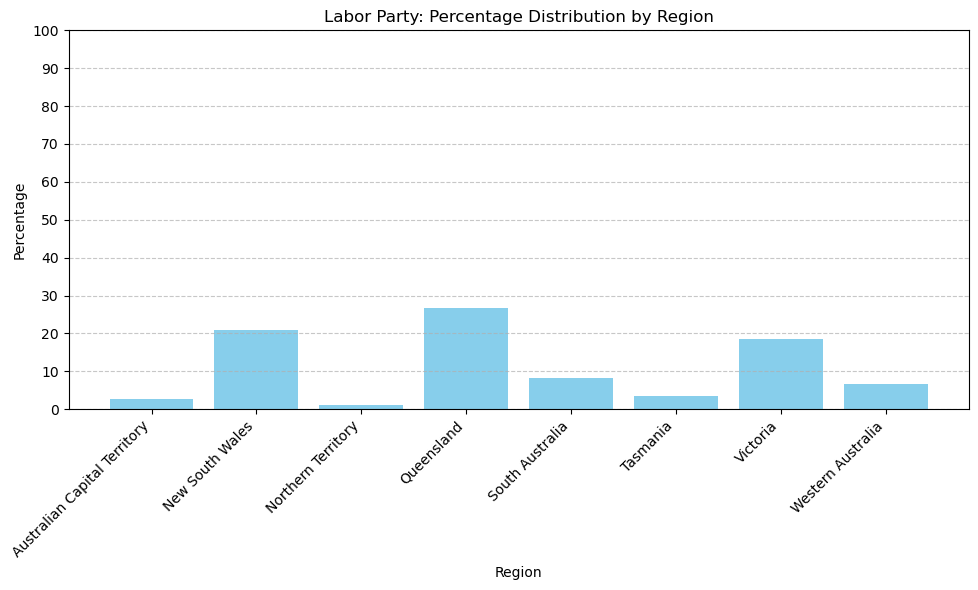

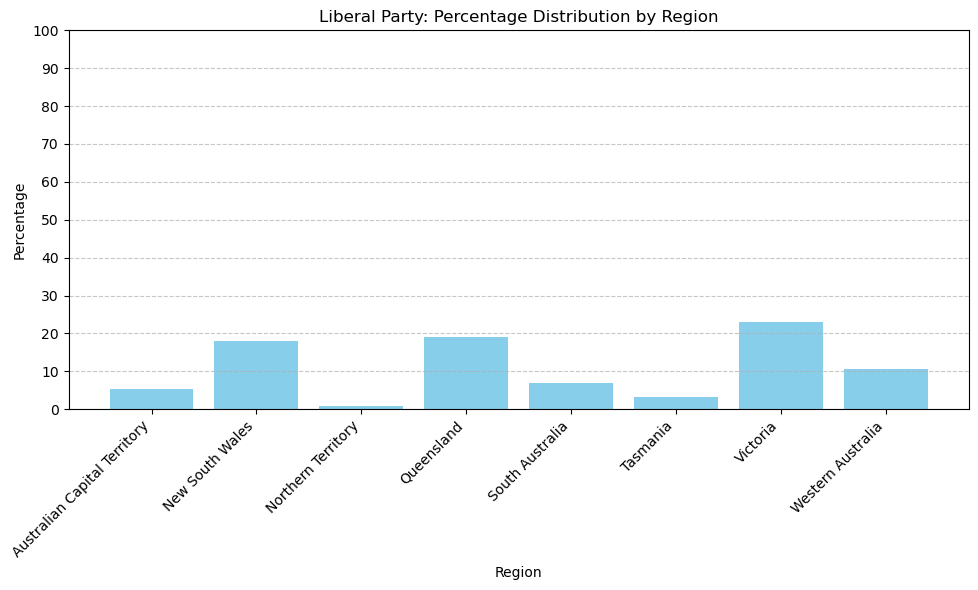

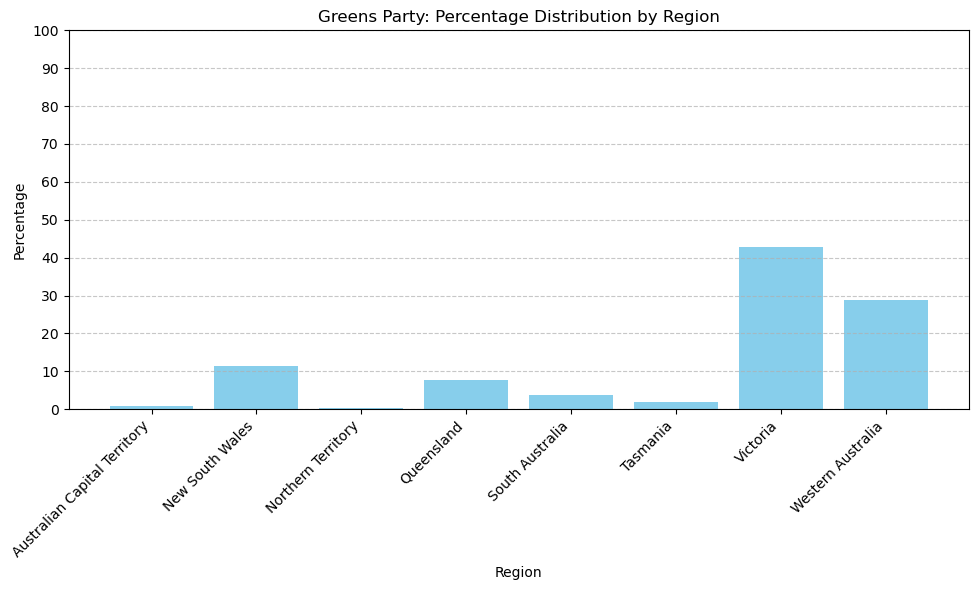

In [23]:
# Function to plot the graph for a party
def plot_party_graph(df, party_name):
    # Sort the DataFrame by 'region'
    df_sorted = df.sort('region')

    # Extract regions and percentages
    regions = df_sorted.select('region').rdd.flatMap(lambda x: x).collect()
    percentages = df_sorted.select('proportion').rdd.flatMap(lambda x: x).collect()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(regions, percentages, color='skyblue')
    plt.xlabel('Region')
    plt.ylabel('Percentage')
    plt.title(f'{party_name} Party: Percentage Distribution by Region')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(range(0, 101, 10))
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot graphs for each party
plot_party_graph(labor_region_sum_df, 'Labor')
plot_party_graph(liberal_region_sum_df, 'Liberal')
plot_party_graph(greens_region_sum_df, 'Greens')

In [24]:
# Calculte the estimated audience size for each of the parties:

# Function to calculate sum, count, and average
def calculate_stats(df, party_name):
    # Replace null values with 0
    df = df.withColumn("lower_bound", when(df["estimated_audience_size.lower_bound"].isNull(), 0).otherwise(df["estimated_audience_size.lower_bound"]))
    df = df.withColumn("upper_bound", when(df["estimated_audience_size.upper_bound"].isNull(), 0).otherwise(df["estimated_audience_size.upper_bound"]))
    
    # Calculate sum of lower_bound and upper_bound
    sum_lower_bound = df.selectExpr("sum(CAST(lower_bound AS FLOAT)) AS sum_lower_bound").collect()[0]["sum_lower_bound"]
    sum_upper_bound = df.selectExpr("sum(CAST(upper_bound AS FLOAT)) AS sum_upper_bound").collect()[0]["sum_upper_bound"]
    
    # Calculate count
    count = df.count()
    
    # Calculate average
    average = (sum_lower_bound + sum_upper_bound) / count
    
    return (party_name, sum_lower_bound, sum_upper_bound, count, average)

# Calculate stats for each party
labor_stats = calculate_stats(labor_df, 'Labor')
liberal_stats = calculate_stats(liberal_df, 'Liberal')
greens_stats = calculate_stats(greens_df, 'Greens')

# Create DataFrame
summary_df = spark_session.createDataFrame([labor_stats, liberal_stats, greens_stats], ["Party", "Lower Bound Sum", "Upper Bound Sum", "Count", "Average"])

# Show the result
summary_df.show()

+-------+---------------+---------------+-----+------------------+
|  Party|Lower Bound Sum|Upper Bound Sum|Count|           Average|
+-------+---------------+---------------+-----+------------------+
|  Labor|      5608056.0|        1.831E7|12242|1953.7702989707564|
|Liberal|      2300007.0|       900000.0| 6253|511.75547737086197|
| Greens|     1.044002E7|      1600000.0| 1409| 8545.081618168913|
+-------+---------------+---------------+-----+------------------+



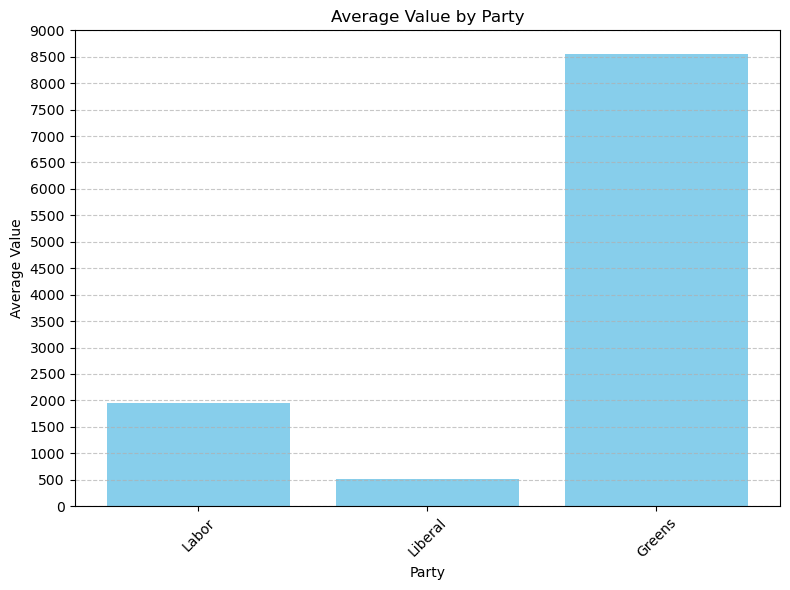

In [25]:
# Make a plot of the Estimated Audience Size:

# Extract party names and average values
parties = summary_df.select('Party').rdd.flatMap(lambda x: x).collect()
averages = summary_df.select('Average').rdd.flatMap(lambda x: x).collect()

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(parties, averages, color='skyblue')
plt.xlabel('Party')
plt.ylabel('Average Value')
plt.title('Average Value by Party')
plt.xticks(rotation=45)
plt.yticks(range(0, int(max(averages)) + 500, 500))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [31]:
from pyspark.sql.functions import col, lit, date_format
from pyspark.sql import Window
import pyspark.sql.functions as F

# Function to calculate YYYY-MM counts and add party name
def calculate_counts_with_party(df, party_name):
    counts = (
        df.withColumn("month-year", date_format(col("ad_creation_time"), "yyyy-MM"))
        .groupBy("month-year")
        .agg(F.count("*").alias("count"))
        .withColumn("party", lit(party_name))
        .select("month-year", "count", "party")
        .orderBy("month-year")
    )
    return counts

# Calculate counts for each DataFrame
labor_counts = calculate_counts_with_party(labor_df, "labor")
liberal_counts = calculate_counts_with_party(liberal_df, "liberal")
greens_counts = calculate_counts_with_party(greens_df, "greens")
election_counts = calculate_counts_with_party(election_df, "election")

# Union the DataFrames
combined_counts = labor_counts.union(liberal_counts).union(greens_counts).union(election_counts)

# Show the results
combined_counts.show()

24/05/12 12:16:19 WARN DAGScheduler: Broadcasting large task binary with size 1327.6 KiB


+----------+-----+-----+
|month-year|count|party|
+----------+-----+-----+
|   2020-03|   49|labor|
|   2020-04|    5|labor|
|   2020-05|   27|labor|
|   2020-06|   27|labor|
|   2020-07|   11|labor|
|   2020-08|   43|labor|
|   2020-09|  427|labor|
|   2020-10|  622|labor|
|   2020-11|   33|labor|
|   2020-12|   16|labor|
|   2021-01|   49|labor|
|   2021-02|  263|labor|
|   2021-03|  136|labor|
|   2021-04|  110|labor|
|   2021-05|  362|labor|
|   2021-06| 1018|labor|
|   2021-07|  706|labor|
|   2021-08|  865|labor|
|   2021-09|  228|labor|
|   2021-10|   96|labor|
+----------+-----+-----+
only showing top 20 rows



In [32]:
combined_counts.show(100)

24/05/12 12:22:54 WARN DAGScheduler: Broadcasting large task binary with size 1327.7 KiB
24/05/12 12:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1327.7 KiB


+----------+-----+--------+
|month-year|count|   party|
+----------+-----+--------+
|   2020-03|   49|   labor|
|   2020-04|    5|   labor|
|   2020-05|   27|   labor|
|   2020-06|   27|   labor|
|   2020-07|   11|   labor|
|   2020-08|   43|   labor|
|   2020-09|  427|   labor|
|   2020-10|  622|   labor|
|   2020-11|   33|   labor|
|   2020-12|   16|   labor|
|   2021-01|   49|   labor|
|   2021-02|  263|   labor|
|   2021-03|  136|   labor|
|   2021-04|  110|   labor|
|   2021-05|  362|   labor|
|   2021-06| 1021|   labor|
|   2021-07|  706|   labor|
|   2021-08|  865|   labor|
|   2021-09|  228|   labor|
|   2021-10|   96|   labor|
|   2021-11|   96|   labor|
|   2021-12|   44|   labor|
|   2022-01|   46|   labor|
|   2022-02|  263|   labor|
|   2022-03| 1332|   labor|
|   2022-04| 2333|   labor|
|   2022-05| 2996|   labor|
|   2022-06|   39|   labor|
|   2020-03|   14| liberal|
|   2020-04|    1| liberal|
|   2020-05|    4| liberal|
|   2020-06|    4| liberal|
|   2020-07|   15| l

In [ ]:
# Calculate demographic distribution percentages for each party:

# Explode the demographic_distribution array column
exploded_df_labor = labor_df.select(explode('demographic_distribution').alias('demographic_info')).select(col('demographic_info.percentage').cast('float').alias('percentage'), col('demographic_info.age'), col('demographic_info.gender'))
exploded_df_liberal = liberal_df.select(explode('demographic_distribution').alias('demographic_info')).select(col('demographic_info.percentage').cast('float').alias('percentage'), col('demographic_info.age'), col('demographic_info.gender'))
exploded_df_greens = greens_df.select(explode('demographic_distribution').alias('demographic_info')).select(col('demographic_info.percentage').cast('float').alias('percentage'), col('demographic_info.age'), col('demographic_info.gender'))

# Group by 'region' and calculate the sum of 'percentage' for each region
labor_age_sum_df = exploded_df_labor.groupBy('age').sum('percentage').withColumnRenamed('sum(percentage)', 'age_percentage')
labor_gender_sum_df = exploded_df_labor.groupBy('gender').sum('percentage').withColumnRenamed('sum(percentage)', 'gender_percentage')
liberal_age_sum_df = exploded_df_liberal.groupBy('age').sum('percentage').withColumnRenamed('sum(percentage)', 'age_percentage')
liberal_gender_sum_df = exploded_df_liberal.groupBy('gender').sum('percentage').withColumnRenamed('sum(percentage)', 'gender_percentage')
greens_age_sum_df = exploded_df_greens.groupBy('age').sum('percentage').withColumnRenamed('sum(percentage)', 'age_percentage')
greens_gender_sum_df = exploded_df_greens.groupBy('gender').sum('percentage').withColumnRenamed('sum(percentage)', 'gender_percentage')

# Calculate proportions
labor_total_records = labor_df.count()
labor_age_sum_df = labor_age_sum_df.withColumn('proportion', (col('age_percentage') / labor_total_records) * 100)
labor_gender_sum_df = labor_gender_sum_df.withColumn('proportion', (col('gender_percentage') / labor_total_records) * 100)
liberal_total_records = liberal_df.count()
liberal_age_sum_df = liberal_age_sum_df.withColumn('proportion', (col('age_percentage') / liberal_total_records) * 100)
liberal_gender_sum_df = liberal_gender_sum_df.withColumn('proportion', (col('gender_percentage') / liberal_total_records) * 100)
greens_total_records = greens_df.count()
greens_age_sum_df = greens_age_sum_df.withColumn('proportion', (col('age_percentage') / greens_total_records) * 100)
greens_gender_sum_df = greens_gender_sum_df.withColumn('proportion', (col('gender_percentage') / greens_total_records) * 100)

# Show the result
print("Labor Party")
labor_age_sum_df.show()
labor_gender_sum_df.show()
print("\nLiberal Party")
liberal_age_sum_df.show()
liberal_gender_sum_df.show()
print("\nGreens Party")
greens_age_sum_df.show()
greens_gender_sum_df.show()

In [40]:
# Stop the spark session

#spark_session.stop()

In [1]:
# REFERENCE CODE:

#df_id_unique.select('bylines').show(100,truncate=False)

#drop_columns = ['bylines', 'currency', 'delivery_by_region', 'demographic_distribution', 'estimated_audience_size', 'spend']
#political_df = df_id_unique.dropna(subset=drop_columns)

#page_counts = political_df.groupBy("page_id", "page_name").agg(count("*").alias("count"))
#page_counts = page_counts.orderBy("count", ascending=False)
#page_counts.select("page_id", "page_name", "count").show(50,truncate=False)

#page_name = 'Yes23'
#page_analysis = political_df.filter(political_df.page_name == page_name)
#page_analysis.head(5)

# Create a filter condition by checking if any of the specified words are contained in the columns
#from pyspark.sql.functions import lower, array_join
#filter_condition = None
#for word in words_to_search:
#    word_filter = None
#    for column in columns_to_search:
#        if '_bodies' in column or '_captions' in column or '_descriptions' in column or '_titles' in column:
#            if word_filter is None:
#                word_filter = array_contains(lower(explode(col(column))), word.lower())
#            else:
#                word_filter = word_filter | array_contains(lower(explode(col(column))), word.lower())
#        else:
#            if word_filter is None:
#                word_filter = lower(col(column)).contains(word.lower())
#            else:
#                word_filter = word_filter | lower(col(column)).contains(word.lower())
#    if filter_condition is None:
#        filter_condition = word_filter
#    else:
#        filter_condition = filter_condition | word_filter
# Apply the filter condition to the DataFrame
#filtered_df = df_id_unique.filter(filter_condition)

# Save the election_df in HDFS
#election_df.write.json("election_data.json")
#print("Data saved in HDFS")


# Get the most used words in the text columns
#def preprocess_text(text):
#    # Convert to lowercase
#    text = text.lower()
    
#    # Remove punctuations
#    text = re.sub(r'[{}]'.format(string.punctuation), '', text)
    
#    # Remove prepositions and common words
#    common_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "you're", "you've", "you'll", "you'd", "your",
#                    "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "she's", "her", "hers", "herself", "it",
#                    "it's", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this",
#                    "that", "that'll", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had",
#                    "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
#                    "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above",
#                    "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
#                    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no",
#                    "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "don't", "should",
#                    "should've", "now", "d", "ll", "m", "o", "re", "ve", "y", "ain", "aren", "aren't", "couldn", "couldn't", "didn", "didn't",
#                    "doesn", "doesn't", "hadn", "hadn't", "hasn", "hasn't", "haven", "haven't", "isn", "isn't", "ma", "mightn", "mightn't",
#                    "mustn", "mustn't", "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't", "wasn", "wasn't", "weren", "weren't",
#                    "won't", "wouldn", "wouldn't", "make", "need", "new", "1", "get", "better", "help", "us",
#                    "time", "like", "care", "one", "–", "que", "want", "back", "today", "find", "year", "years",
#                    "see", "action", "mp", "de", "sign", "keep", "know", "take", "would", "early", "ward", "strong", "first",
#                    "also", "every", "many", "join", "✅", "day", "last", "could"]
    
#    text = ' '.join(word for word in text.split() if word not in common_words)
    
#    return text

#def get_combined_text(row):
#    text = ""
#    for column in ['ad_creative_body', 'ad_creative_link_caption', 'ad_creative_link_description', 'ad_creative_link_title']:
#        if row[column]:
#            text += preprocess_text(row[column]) + " "
    
#    for column in ['ad_creative_bodies', 'ad_creative_link_captions', 'ad_creative_link_descriptions', 'ad_creative_link_titles']:
#        if row[column]:
#            text += " ".join(preprocess_text(item) for item in row[column]) + " "
    
#    return text.strip()

## Combine text from all relevant columns
#combined_text = df_id_unique.rdd.map(get_combined_text).filter(lambda x: x)

## Count word frequencies
#word_counts = combined_text.flatMap(lambda text: text.split()).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)

## Get the top 200 words
#top_words = word_counts.takeOrdered(200, key=lambda x: (-x[1], x[0]))

## Print the top 50 words
#for word, count in top_words:
#    print(f"{word}: {count}")